<center><h1>Exploratory Data Analysis</h1></center>

The purpose of this notebook will be to discover what factors most strongly correlate to a player's fantasy performance.

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

# ps for past season, hs for history seasons
ps_df = pd.read_csv('../data/last_season.csv', index_col=0)
hs_df = pd.read_csv('../data/final_history.csv', index_col=0)

We will begin with the aggregated historical data from seasons 2006/07 - 2022/23. Some players may not have data for the entire range due to transfers (i.e. not being in the league at the time therefore having no data).

We should begin by cleaning the data and reducing repetitive or unnecessary columns. 
In the history seasons dataframe, only the `element_code` column is now repetitive and unnecessary in our current objective since we have already matched this code to the player's name.

In [2]:
hs_df = hs_df.drop(['element_code'], axis=1)

In [3]:
hs_df.head()
print(f"{hs_df.shape}")

(2996, 29)


Let's see the relationship between `total_points` earned in a fantasy season and the `ict_index` which combines statistics for a player's influence, creativity and threat.

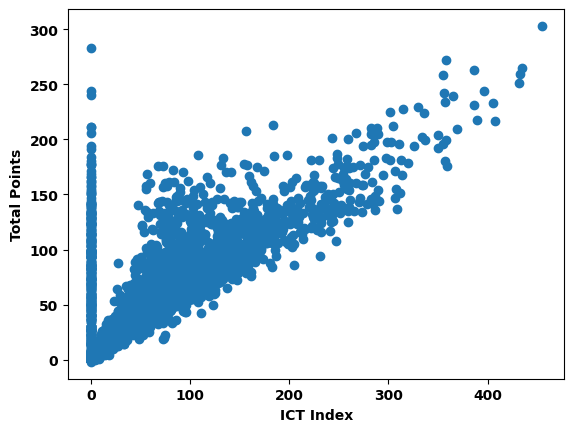

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(hs_df['ict_index'], hs_df['total_points'])
plt.xlabel('ICT Index')
plt.ylabel('Total Points')
plt.show()

The general trend is that the higher the ICT index the greater amount of points earned by the player. Although there are signficant outliers when the ICT index is 0, these seem to be wildcards where there may not have been enough prior information on the player. Let's check out these columns in our dataframe.

In [5]:
hs_df.loc[hs_df['ict_index'] == 0, ['name','position','season_name', 'start_cost', 'end_cost', 'total_points', 'influence', 'creativity', 'threat', 'ict_index']].sort_values('total_points', ascending=False)

,name,position,season_name,start_cost,end_cost,total_points,influence,creativity,threat,ict_index
1909,Cristiano Ronaldo dos Santos Aveiro,FWD,2007/08,120,137,283,0.0,0.0,0.0,0.0
1908,Cristiano Ronaldo dos Santos Aveiro,FWD,2006/07,100,122,244,0.0,0.0,0.0,0.0
1796,Riyad Mahrez,MID,2015/16,55,72,240,0.0,0.0,0.0,0.0
2606,Harry Kane,FWD,2015/16,95,102,211,0.0,0.0,0.0,0.0
1369,Jamie Vardy,FWD,2015/16,60,74,211,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1175,Anthony Knockaert,MID,2022/23,50,47,0,0.0,0.0,0.0,0.0
1176,Nathaniel Chalobah,MID,2011/12,45,45,0,0.0,0.0,0.0,0.0
1177,Nathaniel Chalobah,MID,2012/13,40,38,0,0.0,0.0,0.0,0.0
2990,Mario Lemina,MID,2019/20,50,46,0,0.0,0.0,0.0,0.0


From the above discovery we can see that these values are incorrectly inputted into the FPL API, the players who score high do not have any `ict_index` scores.

We can impute these values based on the average `ict_index` of players with a similar `total_points` output.

In [6]:
to_impute = hs_df.loc[hs_df['ict_index'] == 0,]

In [7]:
to_impute.sort_values('bps', ascending=False).head()

,name,team,position,season_name,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
1796,Riyad Mahrez,MCI,MID,2015/16,55,72,240,3036,17,11,18,26,0,0,2,1,0,0,38,842,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1369,Jamie Vardy,LEI,FWD,2015/16,60,74,211,3133,24,8,14,34,0,0,1,5,1,0,30,831,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2047,Christian Eriksen,MUN,MID,2015/16,85,87,178,2936,6,16,11,32,0,0,0,2,0,0,23,770,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
583,César Azpilicueta,CHE,DEF,2015/16,60,58,124,3199,2,5,8,50,0,0,0,7,0,0,15,760,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2606,Harry Kane,TOT,FWD,2015/16,95,102,211,3363,25,3,14,33,1,0,0,5,0,0,33,748,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


It seems that values for influence, creativity, threat, ict_index, starts, expected_goals, expected_assists, expected_goal_involvements, and expected_goals_conceded are missing for all of these players.

We will attempt to impute the missing values for ict_index only to start with so that we do not overcomplicate the logic to start with.

In [8]:
col_to_impute = hs_df.columns[-9:]
col_to_impute

Index(['influence', 'creativity', 'threat', 'ict_index', 'starts',
       'expected_goals', 'expected_assists', 'expected_goal_involvements',
       'expected_goals_conceded'],
      dtype='object')

In [9]:
# for the missing values we will take the cost and total_points of that player for the season and check for similar rows
# in the original dataframe based on a range of the average difference in cost and average difference in points earned.
# if these values exist we can impute the average of the similar rows ICT index to the missing player
for index, row in to_impute.iterrows():
    cost = row['end_cost']
    total_points = row['total_points']
    similar_rows = hs_df[(hs_df['end_cost'] >= cost - 1) & \
                         (hs_df['end_cost'] <= cost + 1) & \
                         (hs_df['total_points'] >= total_points - 30) & \
                         (hs_df['total_points'] <= total_points + 30) & \
                         (hs_df['ict_index'] != 0)]
    if len(similar_rows) > 0:
        # Imputing missing influence, creativity, threat, ict_index, starts,
        # expected_goals, expected_assists, expected_goal_involvements, expected_goals_conceded
        for col in col_to_impute:
            hs_df.loc[index, f'{col}'] = similar_rows[f'{col}'].mean()

Let's check if there are any rows that do not have any matches and therefore must be dropped from the dataframe.

In [10]:
hs_df.loc[hs_df['ict_index']==0,]

,name,team,position,season_name,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
356,Darren Randolph,BOU,GKP,2006/07,35,35,3,90,0,0,0,2,0,0,0,0,0,4,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,Timo Werner,CHE,FWD,2022/23,80,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1291,Kasper Schmeichel,LEI,GKP,2006/07,35,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1796,Riyad Mahrez,MCI,MID,2015/16,55,72,240,3036,17,11,18,26,0,0,2,1,0,0,38,842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,Cristiano Ronaldo dos Santos Aveiro,MUN,FWD,2006/07,100,122,244,2783,17,16,0,20,0,0,1,2,0,0,36,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909,Cristiano Ronaldo dos Santos Aveiro,MUN,FWD,2007/08,120,137,283,2746,31,7,0,17,0,0,1,5,1,0,35,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1910,Cristiano Ronaldo dos Santos Aveiro,MUN,FWD,2008/09,140,142,206,2742,18,6,0,20,0,0,0,5,1,0,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2434,Theo Walcott,SOU,MID,2012/13,90,93,194,2286,14,13,9,27,0,0,0,3,0,0,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2981,Diego Da Silva Costa,WOL,FWD,2017/18,100,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are approximately 9 rows that could not find similar players to impute to either due to higher cost of player or having a abnormally high total_points. This is the case with Ronaldo from 2007/08 where his end cost and total points was greater than any other player in the dataframes history.

In [11]:
hs_df = hs_df.loc[hs_df['ict_index'] != 0].reset_index()

hs_df.head()
print(f"{hs_df.shape}")

(2987, 30)


As we can see from the above we have now correctly imputed all of the values based on players of similar end cost and total_points achieved. Let's check what the `ict_index` vs `total_points` graph now looks like.

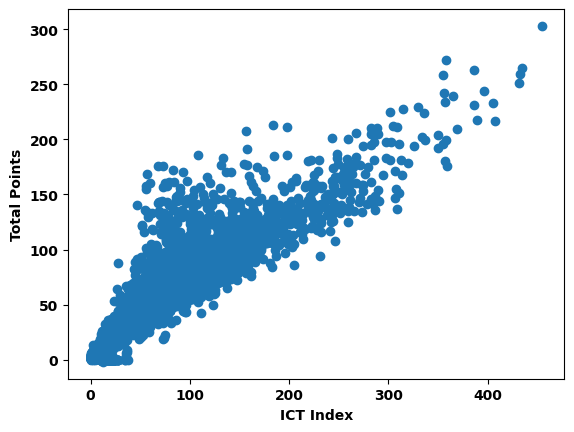

In [12]:
plt.figure()
plt.scatter(hs_df['ict_index'], hs_df['total_points'])
plt.xlabel('ICT Index')
plt.ylabel('Total Points')
plt.show()